In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE
from collections import Counter

## Loading Cleaned Datasets

Our datasets were cleaned in separate Jupyter notebooks.

In [2]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_malaysia_cluster = pickle.load(open('pickle_files/cases_malaysia_cluster.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
aefi_serious = pickle.load(open('pickle_files/aefi_serious.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

## Exploratory Data Analysis

### EDA 1: Analyse which group of population are more vulnerable to covid cases based on cases type in Malaysia.

#### 1.1 cases_malaysia

In [3]:
cases_malaysia.tail(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
617,2021-10-03,9066,12,14454,150146,388,1119,4941,1700,764,5348,1087
618,2021-10-04,8075,6,15456,142746,731,1093,4282,1353,641,5050,948
619,2021-10-05,8817,14,15615,135945,619,1060,5105,1386,686,5624,1007


In [4]:
cases_type = ['cases_new',\
              'cases_import',\
              'cases_recovered',\
              'cases_cluster',\
              'cases_pvax','cases_fvax',\
              'cases_child','cases_adolescent','cases_adult','cases_elderly']
cases_malaysia_melt = cases_malaysia[cases_type].melt()
cases_malaysia_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_melt

,cases_type,count
0,cases_new,4
1,cases_new,0
2,cases_new,0
3,cases_new,0
4,cases_new,3
...,...,...
6195,cases_elderly,1277
6196,cases_elderly,1166
6197,cases_elderly,1087
6198,cases_elderly,948


In [5]:
# sns.set(rc={'figure.figsize':(11,6)})
# sns.set(style="whitegrid", color_codes=True)

# plot_cases_type = sns.swarmplot(x='cases_Type', y='count', data=cases_malaysia_melt)

# plot_cases_type.set_xticklabels(plot_cases_type.get_xticklabels(), rotation=90)
# plot_cases_type.set_title('Cases Type and Count')
# plot_cases_type.set_ylabel('Cases Type')
# plot_cases_type.set_xlabel('Count')

In [6]:
df_casesTotal = cases_malaysia_melt.groupby(["cases_type"]).sum() 
df_casesTotal.reset_index(inplace=True)
df_casesTotal

,cases_type,count
0,cases_adolescent,158432
1,cases_adult,1577927
2,cases_child,304128
3,cases_cluster,473962
4,cases_elderly,182713
5,cases_fvax,343027
6,cases_import,4915
7,cases_new,2294457
8,cases_pvax,373610
9,cases_recovered,2131636


In [7]:
def findCasesByOption(df_casesTotal, options):
    df_optionTotal = df_casesTotal.loc[df_casesTotal['cases_type'].isin(options)]
    df_optionTotal.sort_values('count', axis=0, inplace=True)
    return df_optionTotal

In [8]:
def plotCasesByOption(df_casesTotal, title='', x_label='', y_label='Number of Cases', ymax=2000000):
    sns.set(rc={'figure.figsize':(11,6)})
    sns.set(style="whitegrid", color_codes=True)

    b = sns.barplot(x="cases_type", y="count",  data=df_casesTotal)
    b.set_xticklabels(b.get_xticklabels(), rotation=90)
    b.set_title(title)
    b.set_ylabel(x_label)
    b.set_xlabel(y_label)
    b.set(ylim=(0, ymax))

    for p in b.patches:
            b.annotate("%.0f" % p.get_height(), (p.get_x() + 
        p.get_width() / 2., p.get_height()), 
            ha='center', va='center', rotation=0, 
        xytext=(0, 18), textcoords='offset points')

In [9]:
options = ['cases_child','cases_adolescent','cases_adult','cases_elderly']
df_casesAgeTotal = findCasesByOption(df_casesTotal, options)
df_casesAgeTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
0,cases_adolescent,158432
4,cases_elderly,182713
2,cases_child,304128
1,cases_adult,1577927


In [10]:
ageVerifiedTotal = df_casesAgeTotal['count'].sum()
casesTotal = df_casesTotal[df_casesTotal['cases_type'] == 'cases_new']['count'].sum()
ageUnVerifiedTotal = casesTotal - ageVerifiedTotal
ageUnVerifiedTotal

71257

In [11]:
ageUnVerifiedDict = {'cases_type': 'cases_unverified_age', 'count': ageUnVerifiedTotal}
df_casesAgeTotal = df_casesAgeTotal.append(ageUnVerifiedDict, ignore_index = True,)
df_casesAgeTotal.sort_values('count', axis=0, inplace=True)
df_casesAgeTotal

,cases_type,count
4,cases_unverified_age,71257
0,cases_adolescent,158432
1,cases_elderly,182713
2,cases_child,304128
3,cases_adult,1577927


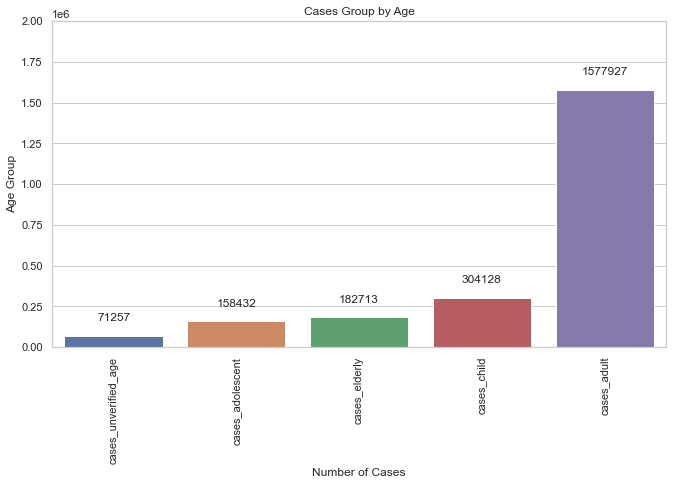

In [12]:
plotCasesByOption(df_casesAgeTotal, 'Cases Group by Age', 'Age Group', 'Number of Cases')

In [13]:
options = ['cases_pvax','cases_fvax']
df_casesGroupByVaccine = findCasesByOption(df_casesTotal, options)
df_casesGroupByVaccine

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
5,cases_fvax,343027
8,cases_pvax,373610


#### 1.2 cases_malaysia_cluster

In [17]:
cases_malaysia_cluster.head(3)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
342,2021-01-01,2068,2,2230,23382,944,0,0,121,76,1721,119,0.0,0.0,35.0,17.0,0.0,18.0,671.0
343,2021-01-02,2295,9,3321,22347,1091,0,0,116,61,1896,117,0.0,2.0,30.0,33.0,0.0,135.0,882.0
344,2021-01-03,1704,5,2726,21317,588,0,0,160,77,1307,118,0.0,0.0,41.0,25.0,0.0,83.0,432.0


In [18]:
cases_type2 = ['cases_new',\
              'cluster_import',\
              'cluster_religious',\
              'cluster_community',\
              'cluster_highRisk',\
              'cluster_education',\
              'cluster_detentionCentre',\
              'cluster_workplace']
cases_malaysia_cluster_melt = cases_malaysia_cluster[cases_type2].melt()
cases_malaysia_cluster_melt.columns = ['cases_type', 'count'] # change column name
cases_malaysia_cluster_melt

,cases_type,count
0,cases_new,2068.0
1,cases_new,2295.0
2,cases_new,1704.0
3,cases_new,1741.0
4,cases_new,2027.0
...,...,...
2219,cluster_workplace,393.0
2220,cluster_workplace,380.0
2221,cluster_workplace,140.0
2222,cluster_workplace,613.0


In [19]:
df_casesClusterTotal = cases_malaysia_cluster_melt.groupby(["cases_type"]).sum() 
df_casesClusterTotal.sort_values('count', axis=0, inplace=True)
df_casesClusterTotal.reset_index(inplace=True)
df_casesClusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
7,cases_new,2181447.0


In [20]:
def getUncategorized(df, overall_column='', new_column_name=''):
    partial_sum = df[df['cases_type'] != overall_column]['count'].sum()
    overall_sum = df[df['cases_type'] == overall_column]['count'].sum()
    uncategorized_subset = overall_sum - partial_sum

    tempDict = {'cases_type': new_column_name, 'count': uncategorized_subset}
    df = df.append(tempDict, ignore_index = True,)
    df.sort_values('count', axis=0, inplace=True)
    return df

In [21]:
clusterTotal = getUncategorized(df_casesClusterTotal, 'cases_new', 'cluster_not_found')
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cases_new']
clusterTotal

,cases_type,count
0,cluster_import,131.0
1,cluster_religious,8194.0
2,cluster_highRisk,8494.0
3,cluster_education,10851.0
4,cluster_detentionCentre,21832.0
5,cluster_community,69732.0
6,cluster_workplace,219381.0
8,cluster_not_found,1842832.0


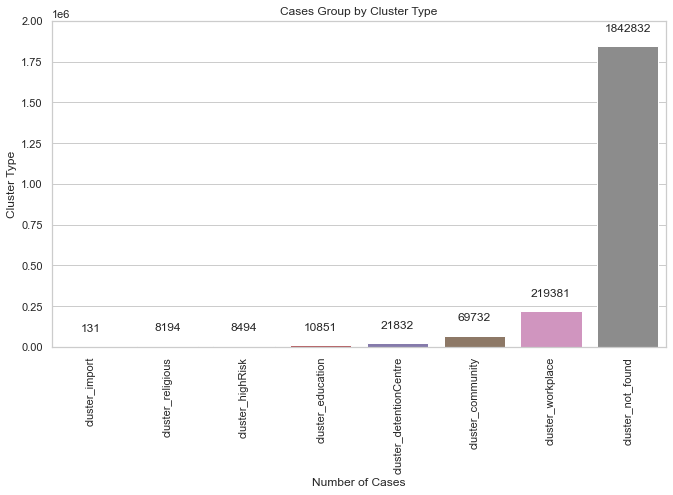

In [22]:
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 2000000)

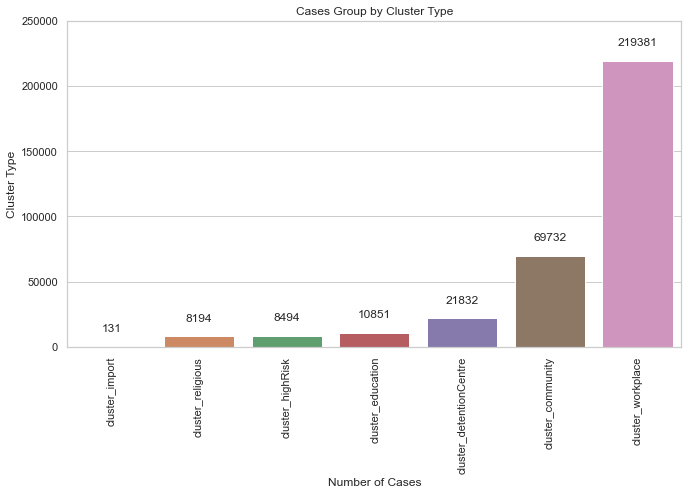

In [23]:
clusterTotal = clusterTotal[clusterTotal['cases_type'] != 'cluster_not_found']
plotCasesByOption(clusterTotal, 'Cases Group by Cluster Type', 'Cluster Type', 'Number of Cases', 250000)

In [24]:
options = ['cases_new','cases_import']
df_casesImportTotal = findCasesByOption(df_casesTotal, options)
df_casesImportTotal

<ipython-input-7-e3fdf8520685>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_optionTotal.sort_values('count', axis=0, inplace=True)


,cases_type,count
6,cases_import,4915
7,cases_new,2294457


### EDA2: What are the vaccination and registration rates per state in Malaysia?

In [47]:
ppl = population.copy()
df = vax_state.groupby('state')['daily_full'].sum()
column = df.keys()
ppl.drop(0,axis=0,inplace=True)
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop'].sum()
    vax_num = vax_state[vax_state['state']==i]['daily_full'].sum()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(cal)
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'percentage'},inplace=True)
           

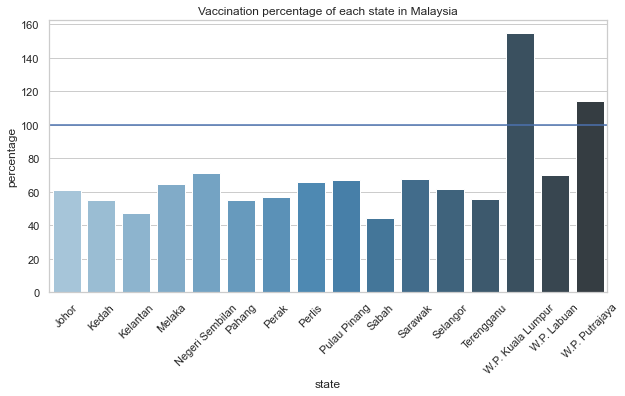

In [48]:
plt.figure(figsize=(10, 5))
graph=sns.barplot(x='state', y='percentage', data=df, palette='Blues_d')
graph.axhline(100)


plt.xticks(rotation=45)
plt.title('Vaccination percentage of each state in Malaysia')
plt.show()

In [49]:
# interactive plot
#fig = px.bar(df,x='state',y='ratio')
#fig.show()  

In [50]:
df = vaxreg_state.groupby('state')['total'].max()
column = df.keys()
state = []
ratio = []
for i in column:
    ppl_num = ppl[ppl['state']==i]['pop']
    vax_num = vaxreg_state[vaxreg_state['state']==i]['total'].max()
    cal = vax_num/ppl_num * 100
    state.append(i)
    ratio.append(int(cal))
df = pd.DataFrame(data=ratio,index=state)
df.reset_index(inplace=True)
df.rename(columns={'index':'state',0:'percentage'},inplace=True)

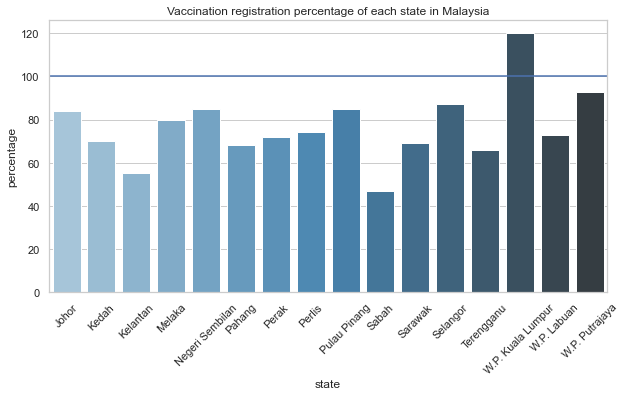

In [51]:
plt.figure(figsize=(10, 5))
graph = sns.barplot(x='state', y='percentage', data=df, palette='Blues_d')
graph.axhline(100)

plt.xticks(rotation=45)
plt.title('Vaccination registration percentage of each state in Malaysia')
plt.show()

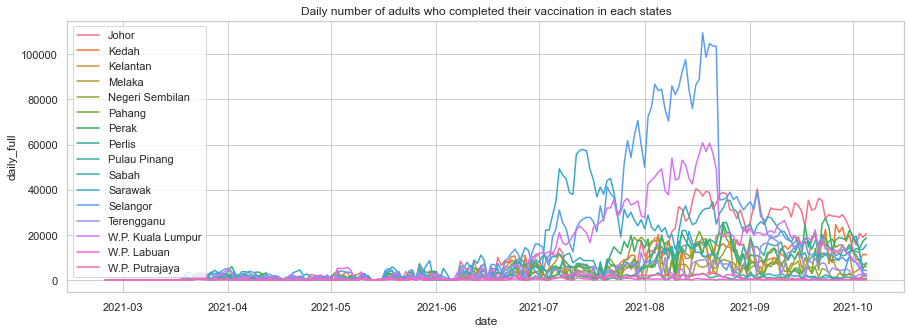

In [53]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vax_state, x='date', y='daily_full', hue='state')
plt.legend()
plt.title('Daily number of adults who completed their vaccination in each states')
plt.show()

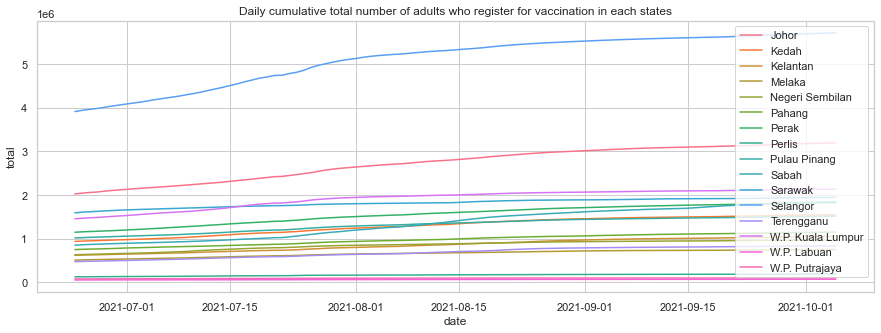

In [54]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=vaxreg_state, x='date', y='total', hue='state')
plt.legend()
plt.title('Daily cumulative total number of adults who register for vaccination in each states')
plt.show()

### EDA 3: What are the types and total number of side effects for each type of vaccine?

In [56]:
df = vax_malaysia[['pfizer1', 'pfizer2','sinovac1', 'sinovac2', 'astra1', 'astra2', 'cansino']].sum()
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df = df.rename(columns={'index':'dose',0:'total'})
df['vaxtype'] = ['pfizer','pfizer','sinovac','sinovac','astra','astra','cansino']

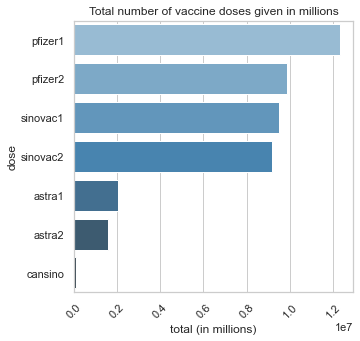

In [57]:
plt.figure(figsize=(5, 5))
sns.barplot(x='total', y='dose', data=df, palette='Blues_d')
plt.xticks(rotation=45)
plt.xlabel('total (in millions)')
plt.title('Total number of vaccine doses given in millions')
plt.show()

In [58]:
# interactive plot (using plotly)
#fig1 = px.bar(df,x='total',y='dose')
#fig1.show()

In [59]:
df = aefi[['vaxtype','d1_site_pain','d1_site_swelling','d1_site_redness','d1_tiredness','d1_headache','d1_muscle_pain','d1_joint_pain','d1_weakness', 'd1_fever','d1_vomiting','d1_chills','d1_rash','d2_site_pain','d2_site_swelling','d2_site_redness','d2_tiredness','d2_headache','d2_muscle_pain','d2_joint_pain','d2_weakness', 'd2_fever','d2_vomiting','d2_chills','d2_rash']].copy()
df = df.groupby('vaxtype').sum()
df2 = aefi_serious.groupby('vaxtype').sum()


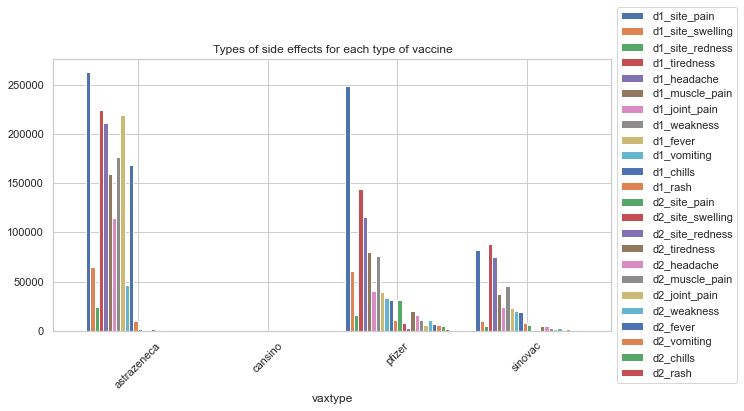

In [60]:
df.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Types of side effects for each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

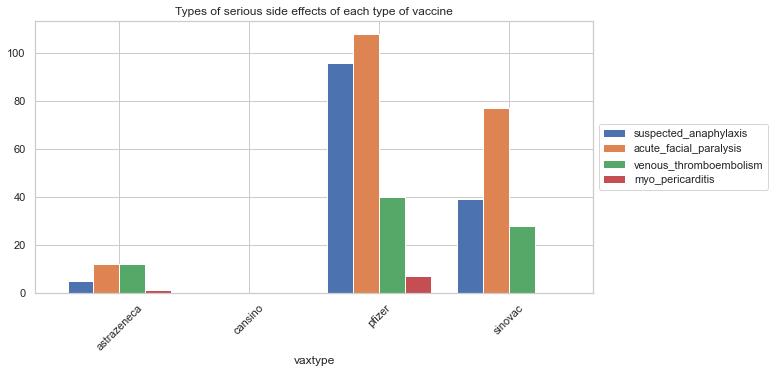

In [61]:
df2.plot.bar(figsize=(10, 5), width=0.8)
plt.title('Types of serious side effects of each type of vaccine')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.show()

### EDA 4:   Which states are recovering? Which of the states shows a decrease in the number of COVID-19 cases?

Since the number of vaccinated entities are increasing, there is a significant decrease in the number of COVID-19 cases in each state. By plotting the moving average of daily confirmed cases and the cumulative number of vaccinated persons against the dates, we can observe that there is a downward trend after the vaccination has reached a certain level in each of the states. The moving average of daily cases is obtained by averaging the number of daily cases in the past 7 days. 

To calculate the daily cumulative number of vaccinated persons, we start by calculating the number of people who completed their vaccination dose. This includes adding the 
* daily number of adults who has completed their 2nd dose of vaccine (either Pfizer, Sinovac or Astra)
* daily number of adults who has taken Cansino (since Cansino only requires 1 dose)
* daily number of children who complete their 2nd dose of Pfizer

These numbers are accumulated to obtain the daily cumulative number of vaccinated persons.


In [68]:
# creating a function to plot 
def plot_cases_vax(state):
   
    # get vaccination status of state
    vax = vax_state[vax_state['state'] == state].copy()
    vax['cumul_cansino'] = vax['cansino'].cumsum()
    vax['cumul_total_vax'] = vax['cumul_full'] + vax['cumul_cansino'] + vax['cumul_full_child'] 
    vax = vax[['date', 'daily', 'cumul_total_vax']].copy()
    vax['date'] = vax['date'].astype('datetime64[ns]')

    # get covid cases of state
    case = cases_state[cases_state['state'] == state][['date', 'cases_new']].copy()
    case['date'] = case['date'].astype('datetime64[ns]')

    # merging both dataframes
    vax_status = pd.merge(vax, case, on='date', how='inner', indicator=True)
    vax_status.drop(['_merge'], axis=1, inplace=True)

    # working on vaccination status
    pop = population.loc[population['state'] == state, 'pop'].values[0]
    
    vax_status['cumul_total_vax_norm'] = vax_status['cumul_total_vax']/pop
    vax_status['cases_new_norm']=(vax_status['cases_new']-vax_status['cases_new'].min())/(vax_status['cases_new'].max()-vax_status['cases_new'].min())
    vax_status['cases_new_ma'] = vax_status['cases_new_norm'].rolling(window=7).mean()
    
    vax_status = vax_status.dropna()
    
    plt.figure(figsize = (20,5))

    plt.plot(vax_status['date'], vax_status['cases_new_norm'], color='pink', label='Daily Confirmed New Cases', linestyle='--') 
    plt.plot(vax_status['date'], vax_status['cases_new_ma'], color='red', label='Daily Confirmed New Cases (7-day Moving Average)') 
    plt.plot(vax_status['date'], vax_status['cumul_total_vax_norm'], color='blue', label='Normalized Cumulative Number of Vaccinated Person') 
    plt.plot(vax_status['date'], pd.Series([1 for i in range(218)]), color='lightgreen', label='State Population', linestyle='--') 
    
    # labeling the date
    x = vax_status['date']
    y = vax_status['cases_new_ma']
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "{:%Y-%m-%d}".format(xmax)

    plt.annotate(text, xy=(xmax+timedelta(days=6), ymax), xytext=(xmax, ymax+0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    # labeling the % of vaccinated people
    y_2 = vax_status['cumul_total_vax_norm']    
    y_val = y_2[np.argmax(y)]
    text_2= "{:.2f}%".format(y_val*100)

    plt.annotate(text_2, xy=(xmax+timedelta(days=6), y_val+0.05), xytext=(xmax++timedelta(days=4), y_val-0.15),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    
    plt.title(state)
    plt.legend()


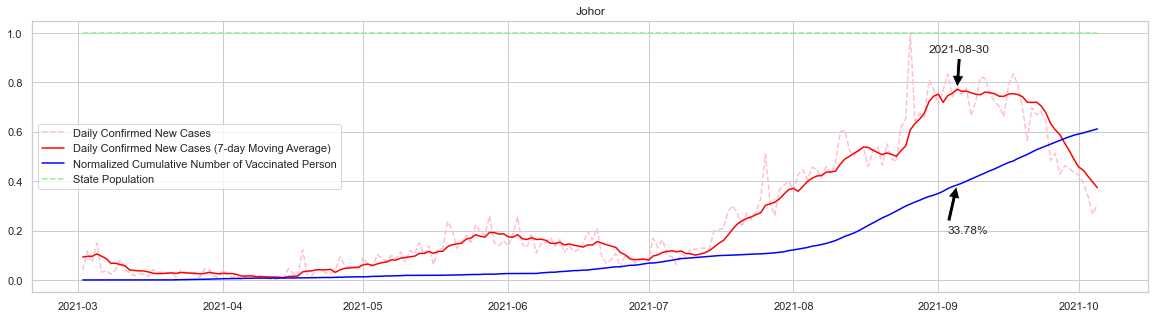

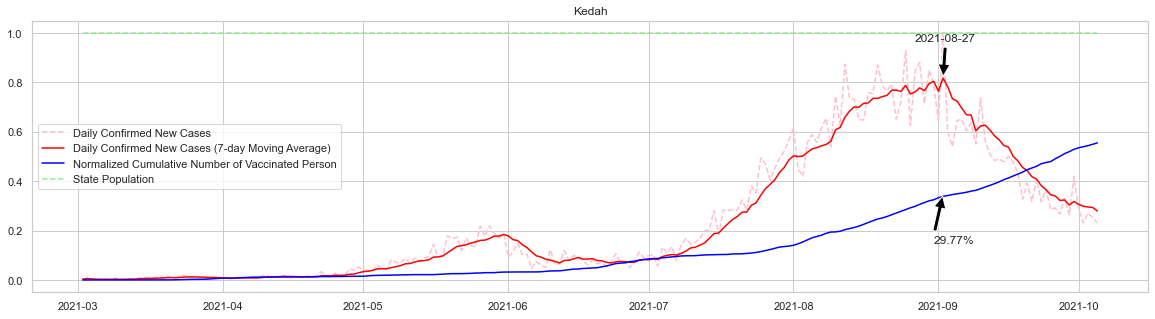

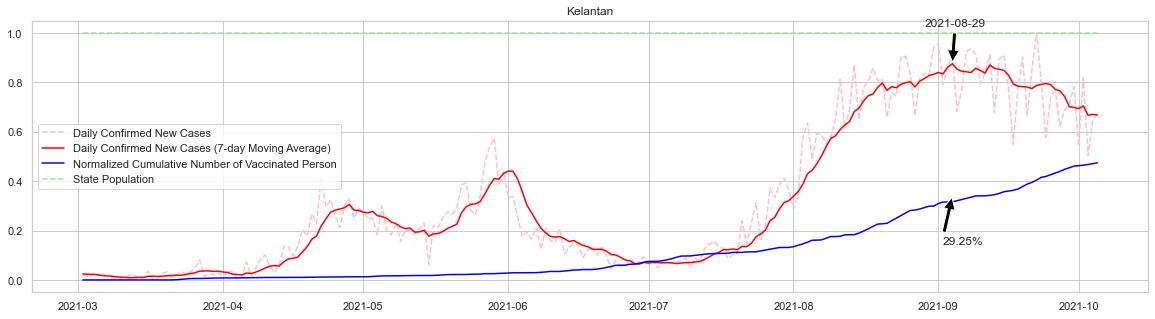

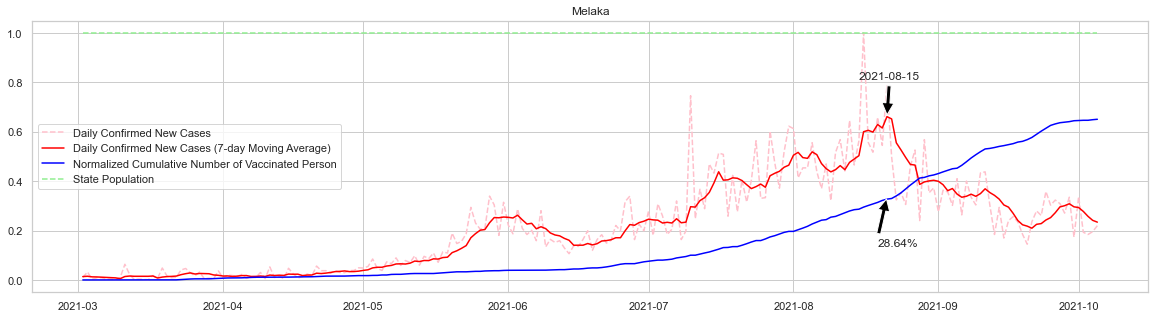

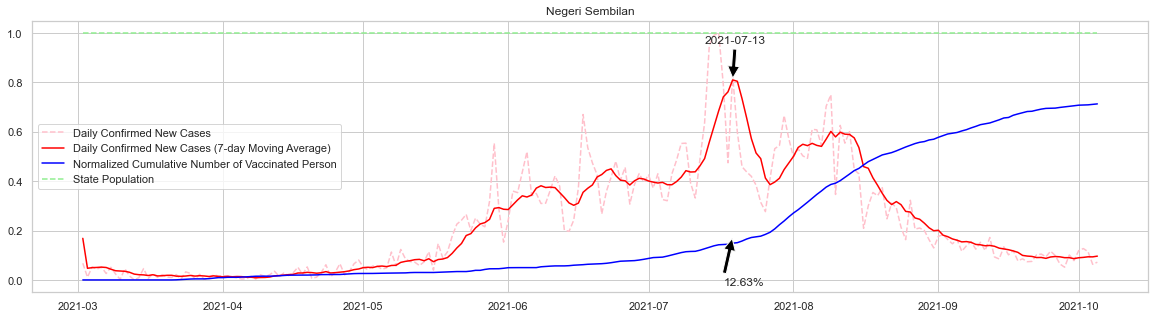

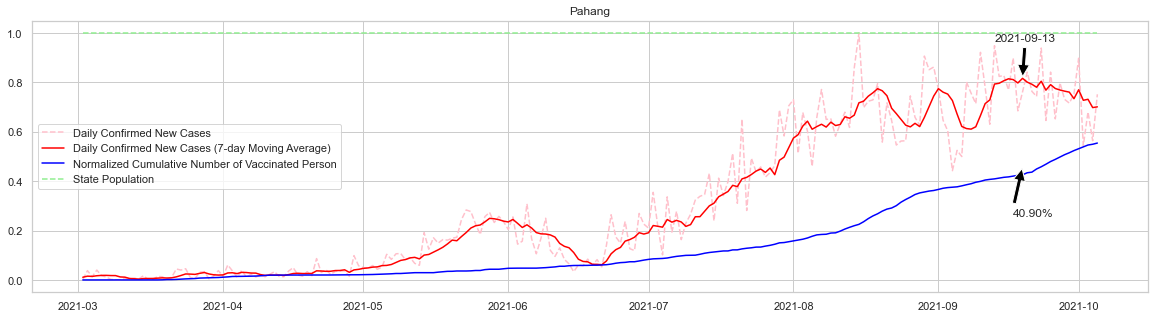

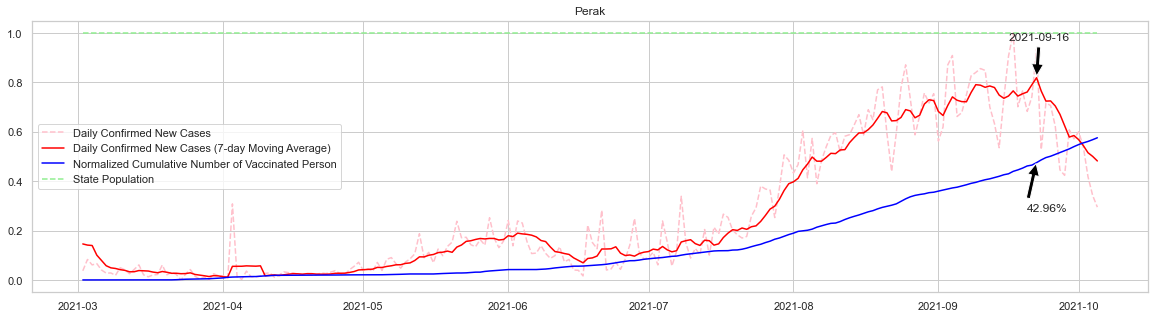

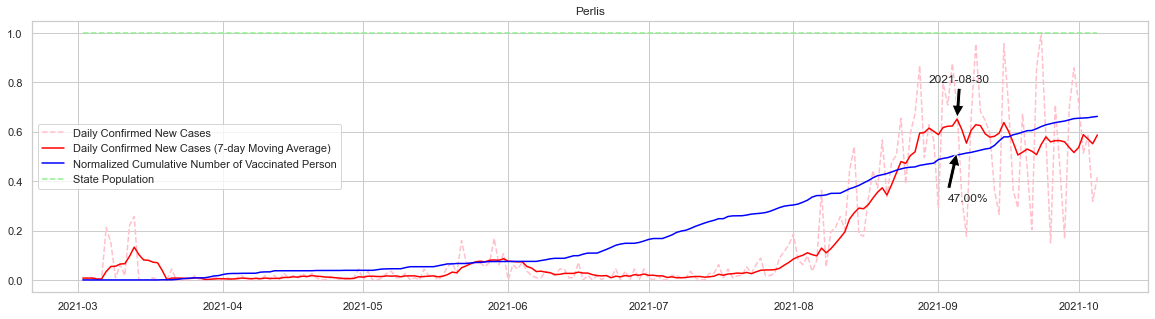

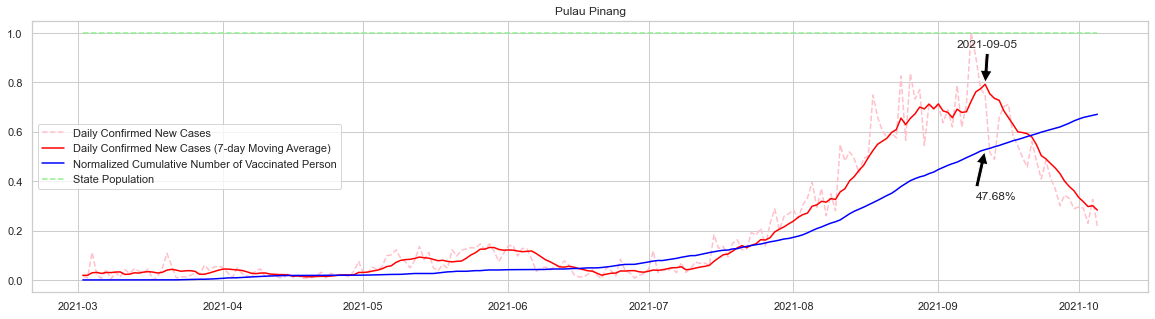

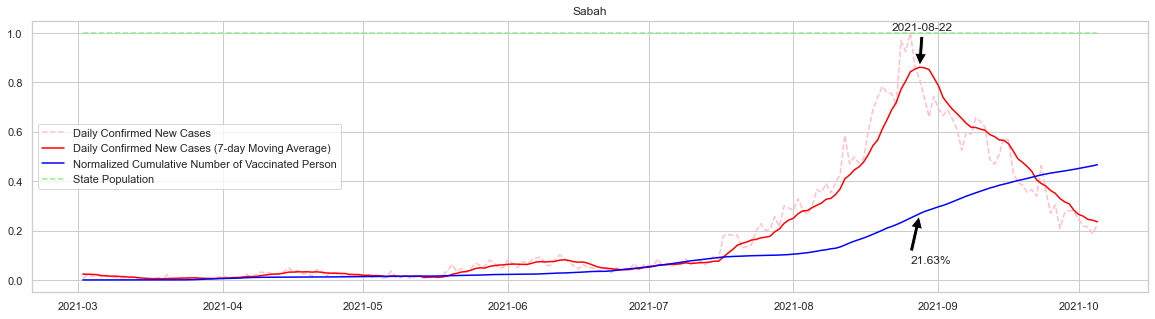

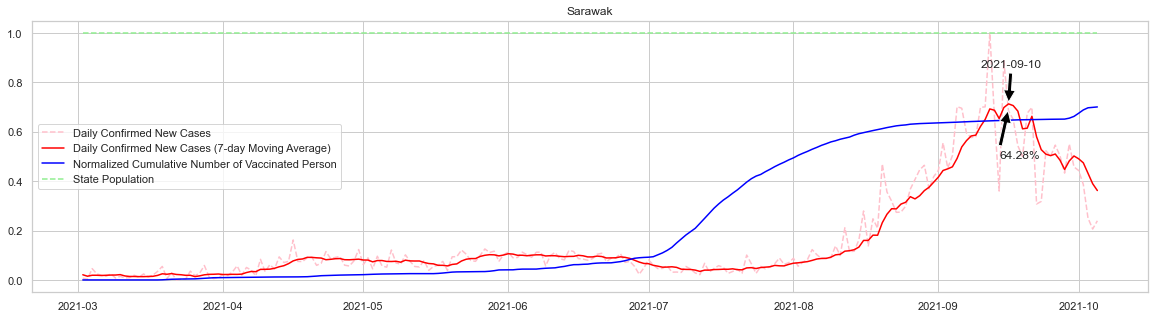

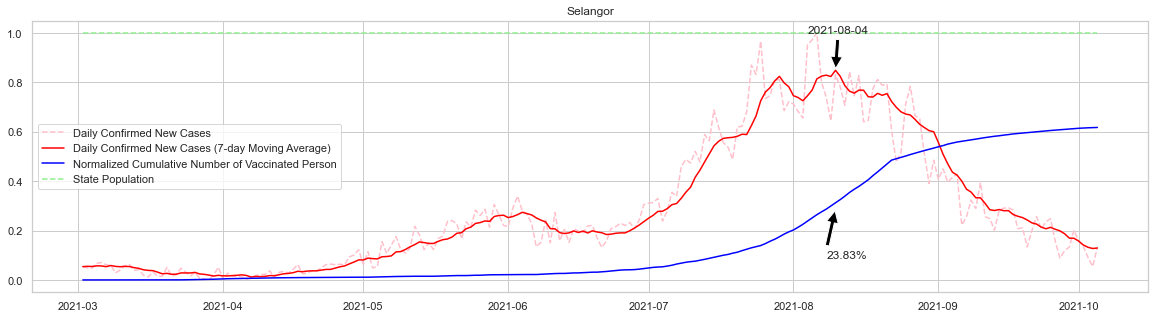

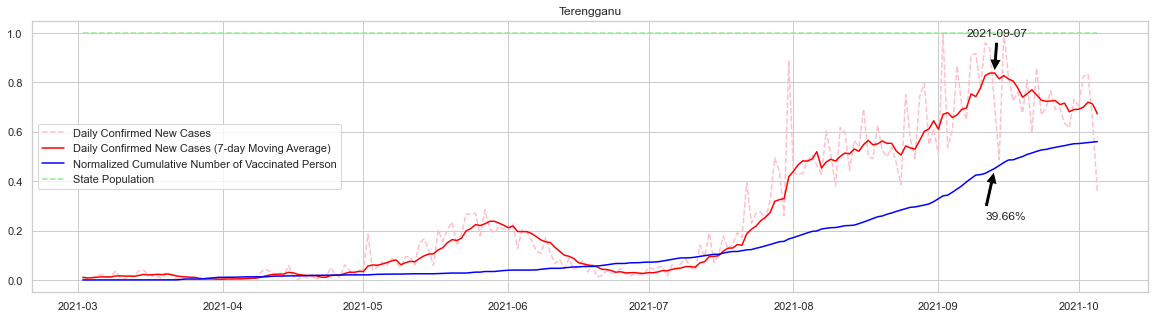

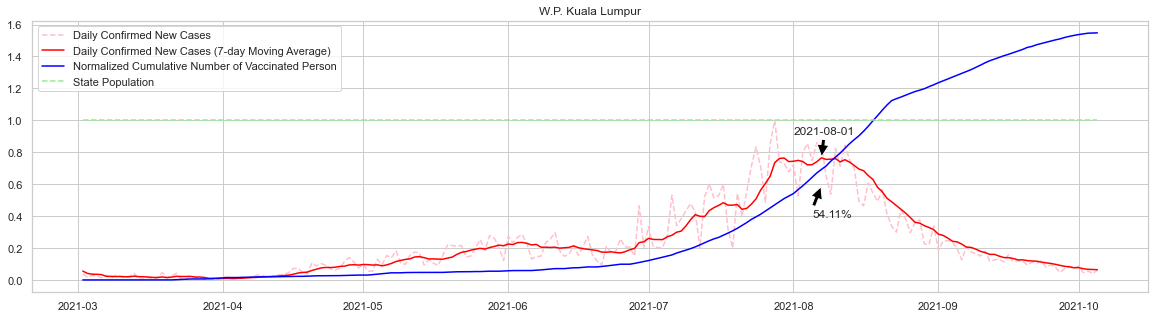

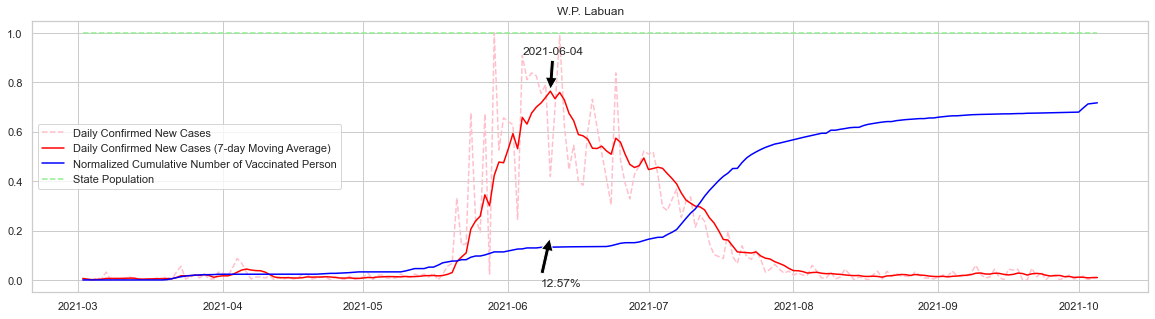

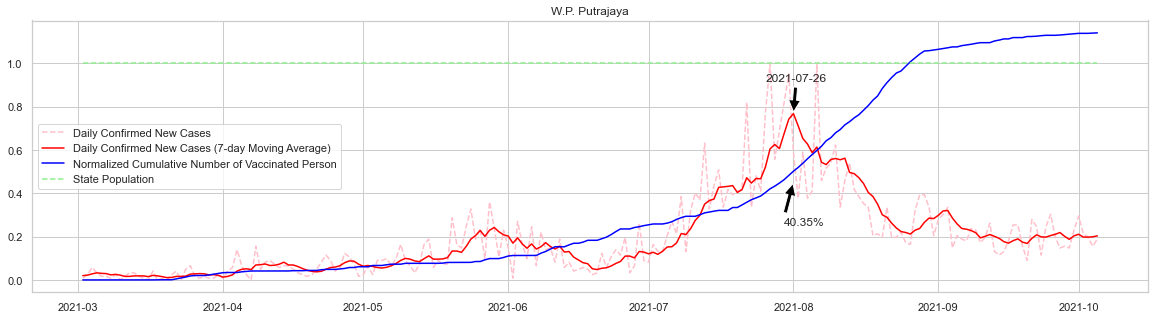

In [69]:
states = vax_state['state'].unique()

for state in states:
    plot_cases_vax(state)

It is observed that the number of vaccinated people in some states has exceeded their state population. The two states that have this phenomena are Kuala Lumpur and Putrajaya. This might be due to foreigners receiving their vaccination shot in our country.

### EDA 5: Rate of Vaccination Serious Side Effect VS COVID-19 Death Rate, which one is more dangerous?


COVID-19 vaccination side effect vs COVID-19 death rate without vaccine, which is scarier? Why should people take vaccine?

In [78]:
ppl = pd.read_csv('dataset/static/population_moh.csv')

In [79]:
total_d = deaths_malaysia['deaths_new'].sum()
total_v  = vax_malaysia['cumul_partial'].max() #number of people atleast obtain first dose of vaccine
total_p = ppl[ppl['state']=='Malaysia']['pop'][0]
not_vaccine = total_p - total_v  # calculate total number of people not getting any vaccine yet
df = aefi_serious.sum()
serious = int(df[1]) + int(df[2]) + int(df[3]) + int(df[4]) # calculate number of people get serious side effect after obtain vaccine

In [80]:
deaths_nvax = deaths_malaysia['deaths_pvax'].sum() + deaths_malaysia['deaths_fvax'].sum()  
deaths_nvax = total_d - deaths_nvax
rate_death_nv = (deaths_nvax / not_vaccine) * 100
rate_death_serious = (serious / total_v) * 100

In [81]:
rate_death_nv = rate_death_nv * 1000 # calculate number of people not obtian vaccine and death because of covid among 1000 people
rate_death_serious = rate_death_serious * 1000  # calculate number of people not obtian serious vaccine side effect among 1000 people

In [82]:
dic = {'Type':['Covid Death Without Vaccine','Obtain Serious Side Effect after injected vaccine'],'Number of case per 1000 people':[rate_death_nv,rate_death_serious]}

In [83]:
bar = pd.DataFrame(dic)
bar

,Type,Number of case per 1000 people
0,Covid Death Without Vaccine,217.970625
1,Obtain Serious Side Effect after injected vaccine,1.764573


Text(0.5, 1.0, 'Bar plot: Number of cases and serious side effect of vaccine amoung 1000 people')

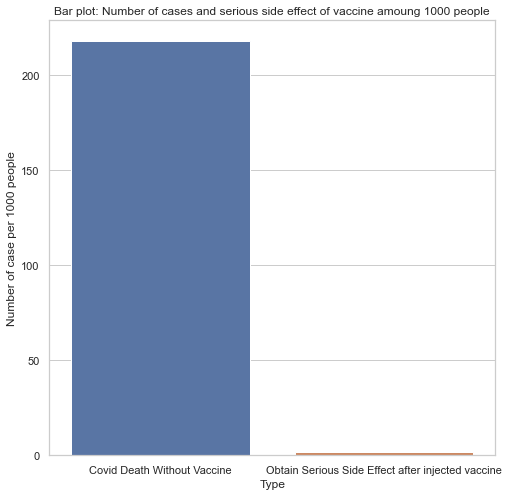

In [84]:
plt.figure(figsize=(8,8))
plot = sns.barplot(data=bar,x='Type',y='Number of case per 1000 people')
plt.title('Bar plot: Number of cases and serious side effect of vaccine amoung 1000 people')#,fontdict = {'fontsize' : 16})

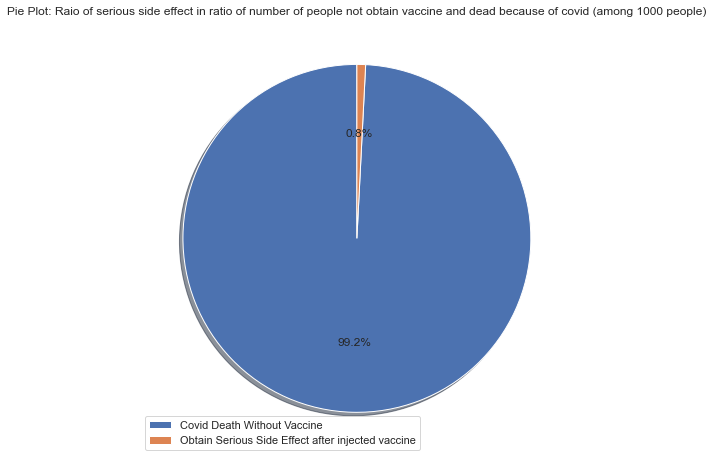

In [85]:
plt.figure(figsize=(8,8))
plt.pie(x=bar['Number of case per 1000 people'], labels= ['',''], autopct='%1.1f%%',shadow=True, startangle=90,)
plt.title('Pie Plot: Raio of serious side effect in ratio of number of people not obtain vaccine and dead because of covid (among 1000 people)')#,fontdict = {'fontsize' : 16})
plt.legend(loc=3, labels=bar['Type'])